In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors

import plotly.graph_objects as go
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter


In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# Configure Seaborn plot styles: Set background color and use white
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='white')

In [4]:
df = pd.read_excel(r'C:\Users\AORUS 15\Desktop\Project 2-REALM OF\REALMOF.xlsx')


In [5]:
print(df.head())
print(df.info())

      OrderId OrderName                 Kind                         Gateway  \
0  1677540287    #10039  Xác nhận thanh toán  Thanh toán khi giao hàng (COD)   
1  1677540287    #10039            Chờ xử lý  Thanh toán khi giao hàng (COD)   
2  1677551016    #10040            Chờ xử lý  Thanh toán khi giao hàng (COD)   
3  1677606361    #10041            Chờ xử lý  Thanh toán khi giao hàng (COD)   
4  1677606361    #10041  Xác nhận thanh toán  Thanh toán khi giao hàng (COD)   

  Payment Method       Date   Amount Currency  HaravanPaymentTransaction  \
0            COD 2025-03-19        0      VND                        NaN   
1            COD 2025-03-19        0      VND                        NaN   
2            COD 2025-03-19  1206000      VND                        NaN   
3            COD 2025-03-19   650000      VND                        NaN   
4            COD 2025-03-27   650000      VND                        NaN   

   ExternalPaymentTransaction  
0                         NaN 

Phân tích dữ liệu

In [6]:
#Chuyển đổi cột ngày thành định dạng datetime và tạo cột Tháng/Năm
df['Date'] = pd.to_datetime(df['Date'])
df['Month_Year'] = df['Date'].dt.to_period('M')

In [7]:
print(df['Date'].head(10))
print(df['Date'].tail(10))
print(df['Date'].isna().sum())


0   2025-03-19
1   2025-03-19
2   2025-03-19
3   2025-03-19
4   2025-03-27
5   2025-03-20
6   2025-03-28
7   2025-03-20
8   2025-03-25
9   2025-03-20
Name: Date, dtype: datetime64[ns]
560   2025-03-18
561   2025-03-18
562   2025-03-18
563   2025-03-18
564   2025-03-21
565   2025-03-19
566   2025-03-20
567   2025-04-06
568   2025-03-19
569   2025-03-26
Name: Date, dtype: datetime64[ns]
0


In [8]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [9]:
df['Month_Year'] = df['Date'].dt.to_period('M').astype(str)


In [10]:
print(df[['Date', 'Month_Year']].head(10))


        Date Month_Year
0 2025-03-19    2025-03
1 2025-03-19    2025-03
2 2025-03-19    2025-03
3 2025-03-19    2025-03
4 2025-03-27    2025-03
5 2025-03-20    2025-03
6 2025-03-28    2025-03
7 2025-03-20    2025-03
8 2025-03-25    2025-03
9 2025-03-20    2025-03


In [11]:
monthly_revenue = df.groupby('Month_Year')['Amount'].sum().reset_index()

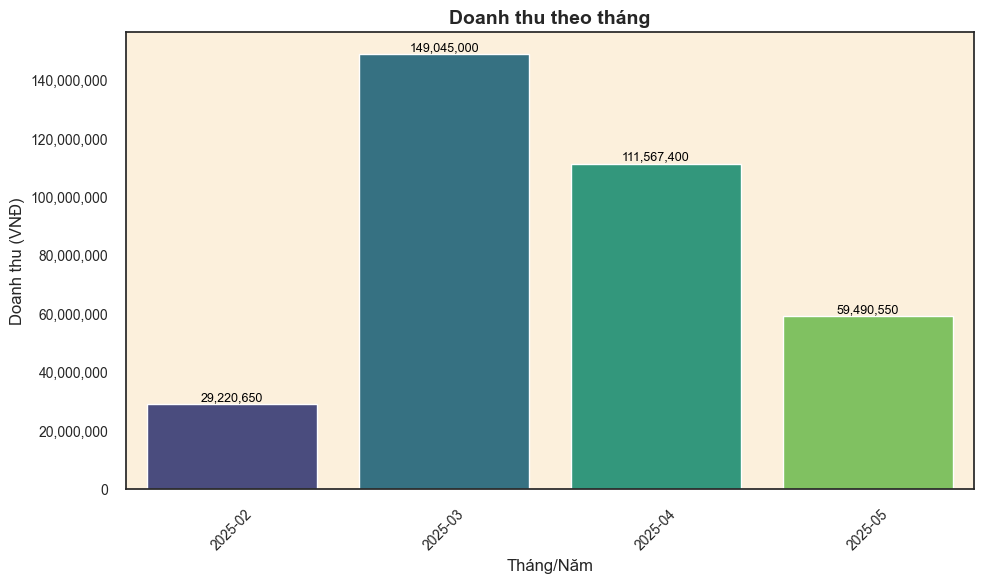

In [12]:
#Doanh thu theo tháng
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Month_Year', y='Amount', data=monthly_revenue, palette='viridis')  # Thử màu viridis xem!

plt.title('Doanh thu theo tháng', fontsize=14, fontweight='bold')
plt.xlabel('Tháng/Năm', fontsize=12)
plt.ylabel('Doanh thu (VNĐ)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Format trục Y có dấu phẩy
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

# Hiện số trên cột
for index, row in monthly_revenue.iterrows():
    ax.text(index, row.Amount, f"{int(row.Amount):,}", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


 Doanh thu theo tháng:
Tháng nào cao nhất, thấp nhất?

Xu hướng tổng quát ra sao?

Có cần tăng doanh thu ở tháng thấp không?

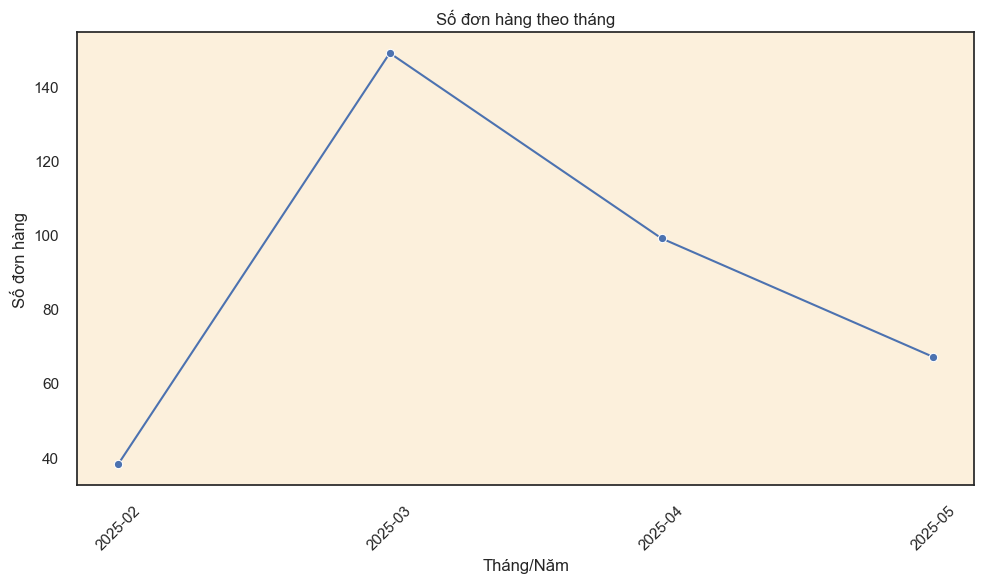

In [13]:
#Số đơn hàng theo tháng
monthly_orders = df.groupby('Month_Year')['OrderId'].nunique().reset_index()
monthly_orders['Month_Year'] = monthly_orders['Month_Year'].astype(str)

plt.figure(figsize=(10,6))
sns.lineplot(x='Month_Year', y='OrderId', data=monthly_orders, marker='o')
plt.title('Số đơn hàng theo tháng')
plt.xlabel('Tháng/Năm')
plt.ylabel('Số đơn hàng')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2️⃣ Số đơn theo tháng:
Tương tự, so sánh cao-thấp.

Có tháng nào ít đơn nhưng AOV cao? (Khách mua ít nhưng giá trị cao).

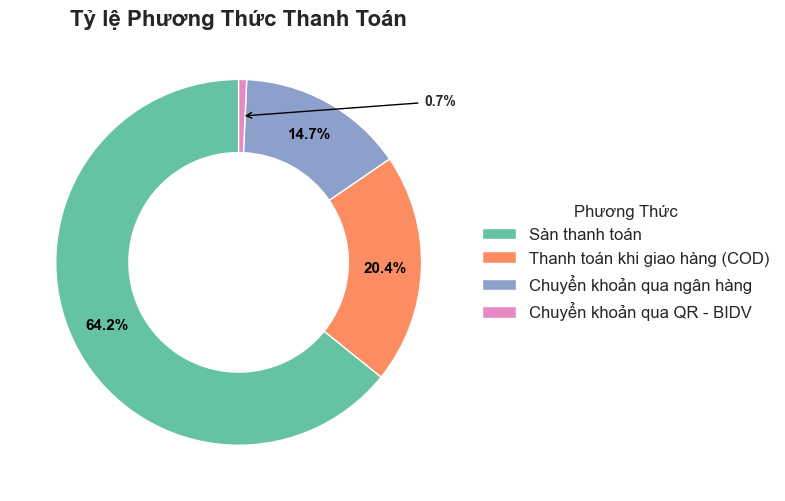

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Tính toán tỉ lệ
payment_counts = df['Gateway'].value_counts(normalize=True).reset_index()
payment_counts.columns = ['Gateway', 'Percentage']
labels = payment_counts['Gateway']
sizes = payment_counts['Percentage'] * 100

# Màu sắc đẹp
colors = sns.color_palette('Set2', len(sizes))

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=None,  # Không hiện label bên ngoài
    autopct='',    # Không auto % vì sẽ custom
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Viết % vào giữa từng miếng
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    x = np.cos(np.deg2rad(ang)) * 0.8  # Giảm từ 0.7 -> 0.55 để nằm bên trong hơn
    y = np.sin(np.deg2rad(ang)) * 0.8

    # Nếu phần trăm nhỏ hơn 2% thì vẽ mũi tên ra ngoài
    if sizes[i] < 2:
        ax.annotate(f"{sizes[i]:.1f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                    arrowprops=dict(arrowstyle="->", color='black'), ha='center', va='center', fontsize=10, fontweight='bold')
    else:
        ax.text(x, y, f"{sizes[i]:.1f}%", ha='center', va='center', fontsize=11, fontweight='bold', color='black')

# Thêm legend bên phải
ax.legend(wedges, labels, title='Phương Thức', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

# Tiêu đề
plt.title('Tỷ lệ Phương Thức Thanh Toán', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


3️⃣ Tỷ lệ phương thức thanh toán:
Phương thức nào chiếm tỷ lệ cao nhất? (Ví dụ: Sàn thanh toán chiếm ~64%).

Có cần khuyến khích khách dùng phương thức khác để giảm rủi ro hoặc phí không?

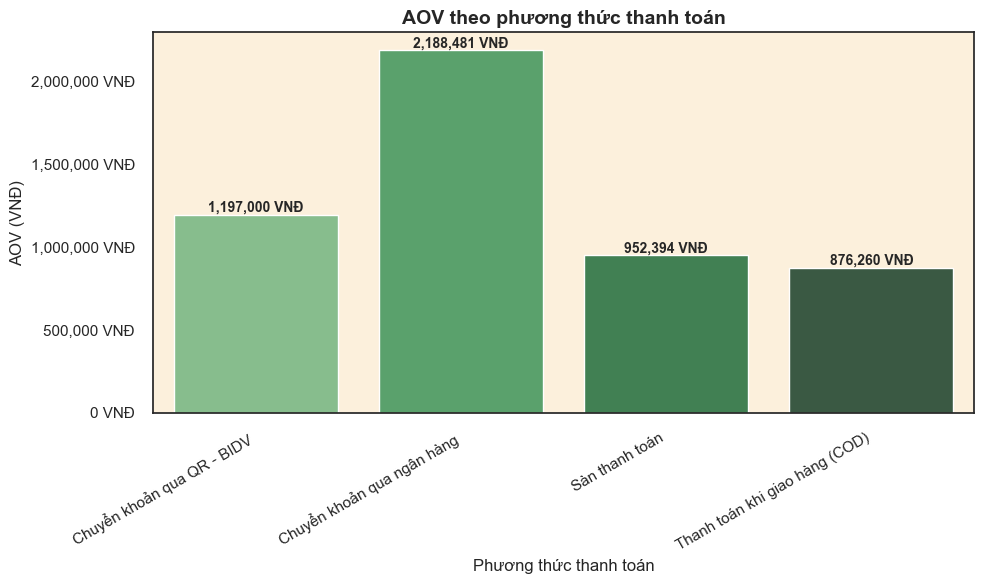

In [15]:
# AOV (Average Order Value) theo phương thức thanh toán
aov = df.groupby('Gateway').agg({'Amount': 'sum', 'OrderId': 'nunique'}).reset_index()
aov['AOV'] = aov['Amount'] / aov['OrderId']

# Vẽ biểu đồ
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Gateway', y='AOV', data=aov, palette='Greens_d')

plt.title('AOV theo phương thức thanh toán', fontsize=14, weight='bold')
plt.xlabel('Phương thức thanh toán', fontsize=12)
plt.ylabel('AOV (VNĐ)', fontsize=12)

# Format trục Y
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f} VNĐ'))

# Hiển thị số trên cột
for index, row in aov.iterrows():
    ax.text(index, row.AOV, f"{int(row.AOV):,} VNĐ", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


AOV theo phương thức:
Phương thức nào có AOV cao nhất? Vì sao?

Có cần đẩy mạnh chuyển khoản không?

In [16]:
#Top 3 tháng có doanh thu cao nhất
top_months = monthly_revenue.sort_values(by='Amount', ascending=False).head(3)
print("Top 3 tháng có doanh thu cao nhất:")
print(top_months)

Top 3 tháng có doanh thu cao nhất:
  Month_Year     Amount
1    2025-03  149045000
2    2025-04  111567400
3    2025-05   59490550


In [17]:
#Tháng có doanh thu thấp nhất cần cải thiện
bottom_month = monthly_revenue.sort_values(by='Amount').head(1)
print("Tháng có doanh thu thấp nhất cần cải thiện:")
print(bottom_month)


Tháng có doanh thu thấp nhất cần cải thiện:
  Month_Year    Amount
0    2025-02  29220650


In [18]:
import pandas as pd

# 1. Load data (giả định file là df rồi nhé)
# df = pd.read_excel('file.xlsx')

# 2. Đổi Date sang datetime
df['Date'] = pd.to_datetime(df['Date'])

# 3. Chọn ngày phân tích (latest date)
latest_date = df['Date'].max()

# 4. Tính RFM
rfm = df.groupby('OrderName').agg({
    'Date': lambda x: (latest_date - x.max()).days,  # Recency
    'OrderId': 'nunique',                            # Frequency
    'Amount': 'sum'                                  # Monetary
}).reset_index()

# 5. Đổi tên cột
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# 6. Xem kết quả
print(rfm.head())


  CustomerID  Recency  Frequency  Monetary
0     #10000       95          1   1380000
1     #10001       95          1   1206000
2     #10002       94          1    530000
3     #10003       94          1    530000
4     #10004       94          1    530000


In [19]:
# Convert InvoiceDate to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Convert InvoiceDate to datetime and extract only the date
df['Day'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

KeyError: 'InvoiceDate'